In [1]:
from uf3.jax.jax_splines import *
from uf3.util.random import random_spline

import jax.numpy as jnp
from jax import jit, grad, vmap, value_and_grad
import jax

import numpy as onp

import ndsplines

import time
import timeit

import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Benchmarks for Splines

## The fastest backend for cubic splines
- (1D and 3D)
- CPU vs GPU

### 1D

In [13]:
seed = 123
dimension = 1
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'cpu_symbolic': (BSplineBackend.Symbolic, 'cpu'),
    'cpu_deBoor' : (BSplineBackend.DeBoor, 'cpu'),
    # 'gpu_symbolic' : (BSplineBackend.Symbolic, 'gpu'),
    # 'gpu_deBoor' : (BSplineBackend.DeBoor, 'gpu')
}

for key in settings.keys():
    timings[key] = None
    backend, device = settings[key]

    for exponent in range(2,100):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)
        s = ndSpline_unsafe(c, k, ds, backend=backend)

        x_jax = jax.device_put(x)

        fn = jit(vmap(s), backend=device)

        sym = lambda : fn(x_jax).block_until_ready()

        try:
            t = timeit.Timer(sym).repeat(repeat=4, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        # print(f"{key}: {size} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break


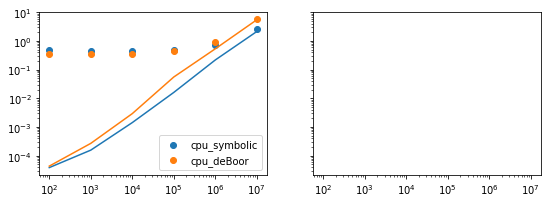

In [14]:
keys = [['cpu_symbolic','cpu_deBoor']] #,['gpu_symbolic','gpu_deBoor']]

fig, axs = plt.subplots(1,2, figsize=(9,3), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = timings[k]
        x = data[:,0]
        y_jit = data[:,1]
        y = onp.mean(data[:,2:], 1)

        ax.plot(x, y)
        ax.set_xscale('log')
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.legend()


plt.show()


### 3D

In [27]:
seed = 123
dimension = 3
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'cpu_symbolic': (BSplineBackend.Symbolic, 'cpu'),
    'cpu_deBoor' : (BSplineBackend.DeBoor, 'cpu'),
    # 'gpu_symbolic' : (BSplineBackend.Symbolic, 'gpu'),
    # 'gpu_deBoor' : (BSplineBackend.DeBoor, 'gpu')
}

for key in settings.keys():
    timings[key] = None
    backend, device = settings[key]

    for exponent in range(2,100):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)
        s = ndSpline_unsafe(c, k, ds, backend=backend)

        x_jax = jax.device_put(x)

        fn = jit(vmap(s), backend=device)

        sym = lambda : fn(x_jax).block_until_ready()

        try:
            t = timeit.Timer(sym).repeat(repeat=4, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        # print(f"{key}: {size} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break


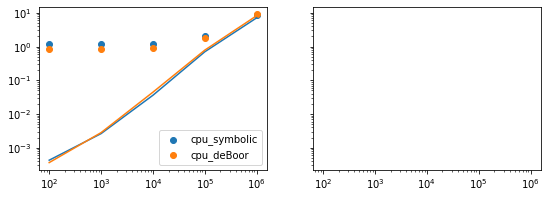

In [28]:
keys = [['cpu_symbolic','cpu_deBoor']] #,['gpu_symbolic','gpu_deBoor']]

fig, axs = plt.subplots(1,2, figsize=(9,3), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = timings[k]
        x = data[:,0]
        y_jit = data[:,1]
        y = onp.mean(data[:,2:], 1)

        ax.plot(x, y)
        ax.set_xscale('log')
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.legend()


plt.show()


## Comparing to other implementations (1D cubic)

- JAX
- ndspline
- scipy

In [9]:
seed = 123
dimension = 1
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.DeBoor, 'cpu'),
    'ND-Splines' : ('ndspline',None,None),
    # 'SciPy' : ('scipy',None,None)
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    for exponent in range(2,7):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(c, k, ds, backend=backend)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(x)
            def fn():
                s(xs)
            sym = fn
        elif name == 'SciPy':
            pass

        try:
            t = timeit.Timer(sym).repeat(repeat=4, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        # print(f"{key}: {size} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break


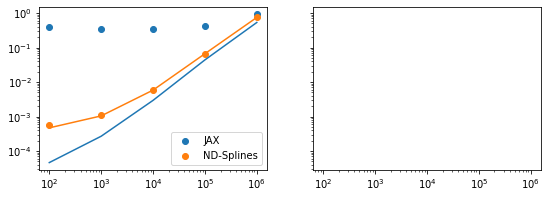

In [11]:
keys = [['JAX','ND-Splines']]

fig, axs = plt.subplots(1,2, figsize=(9,3), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = timings[k]
        x = data[:,0]
        y_jit = data[:,1]
        y = onp.mean(data[:,2:], 1)

        ax.plot(x, y)
        ax.set_xscale('log')
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.legend()


plt.show()


## Effects of higher degrees (deBoor backend and ndspline)

In [10]:
seed = 123
dimension = 1
resolution = 40
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.DeBoor, 'cpu'),
    'ND-Splines' : ('ndspline',None,None),
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    exponent = 4
    for degree in range(3,10):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, degrees=ds, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(c, k, ds, backend=backend)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(x)
            def fn():
                s(xs)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=4, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([degree] + t)
        
        print(f"{key}: {degree} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break


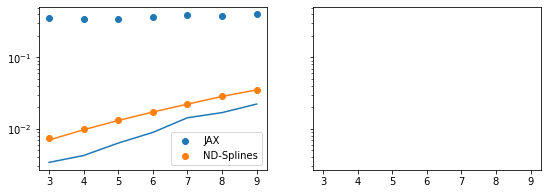

In [13]:
keys = [['JAX','ND-Splines']]

fig, axs = plt.subplots(1,2, figsize=(9,3), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = timings[k]
        x = data[:,0]
        y_jit = data[:,1]
        y = onp.mean(data[:,2:], 1)

        ax.plot(x, y)
        # ax.set_xscale('log')
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.legend()


plt.show()


## Effects of higher dimensions

In [7]:
seed = 123
dimension = 1
resolution = 7
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.DeBoor, 'cpu'),
    'ND-Splines' : ('ndspline',None,None),
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    exponent = 4
    for dimension in range(1,6):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, degrees=ds, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(c, k, ds, backend=backend)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(x)
            def fn():
                s(xs)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=4, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([dimension] + t)
        
        print(f"{key}: {dimension} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break


JAX: 1 - [1.         0.37184307 0.00215248 0.00210369 0.00209343]
JAX: 2 - [2.         0.59516834 0.00552271 0.00530032 0.00515602]
JAX: 3 - [3.         0.88453646 0.01130238 0.0111262  0.01176026]
JAX: 4 - [4.         1.20300621 0.01845629 0.02282332 0.02028998]
JAX: 5 - [5.         1.56556496 0.09229232 0.08952707 0.08902356]
ND-Splines: 1 - [1.         0.00536961 0.00521188 0.005203   0.00520142]
ND-Splines: 2 - [2.         0.01278185 0.01280451 0.01266914 0.01269122]
ND-Splines: 3 - [3.         0.03717829 0.0347817  0.03455333 0.0353111 ]
ND-Splines: 4 - [4.         0.13466179 0.13182836 0.13015798 0.13008498]
ND-Splines: 5 - [5.         0.6389279  0.63348008 0.63303493 0.6328341 ]


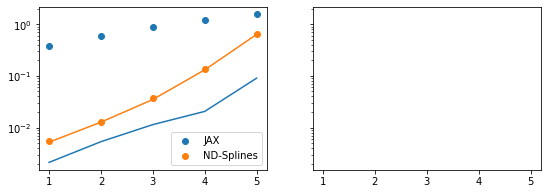

In [9]:
keys = [['JAX','ND-Splines']]

fig, axs = plt.subplots(1,2, figsize=(9,3), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = timings[k]
        x = data[:,0]
        y_jit = data[:,1]
        y = onp.mean(data[:,2:], 1)

        ax.plot(x, y)
        # ax.set_xscale('log')
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.legend()


plt.show()


## Effect of increased knot resolution

1D and 3D splines - fastest backend

# Profiling

In [17]:
seed = 123
size = 1000000
dimension = 3
resolution = 20
degree = 3

res = (resolution,) * dimension
ds = (degree,) * dimension

c, k, x = random_spline(res, sample=size, seed=seed)
s = ndSpline_unsafe(c, k, ds, backend=BSplineBackend.DeBoor, naive_search=True)

x_jax = jax.device_put(x)
fn = jit(vmap(s))
a = fn(x_jax).block_until_ready()

with jax.profiler.trace("/tmp/tensorboard"):
    b = fn(x_jax).block_until_ready()


In [12]:
seed = 123
size = 100000
dimension = 1
resolution = 15
degree = 3

res = (resolution,) * dimension
ds = (degree,) * dimension

c, k, x = random_spline(res, sample=size, seed=seed)

print(len(k[0]))

def search(x):
    return jnp.searchsorted(k[0],x,side='right')

def find(x):
    return jnp.argmax(k[0]>x, 0)

x_jax = jax.device_put(x)
fn1 = jit(vmap(search))
fn2 = jit(vmap(find))
a = fn1(x_jax).block_until_ready()
b = fn2(x_jax).block_until_ready()

# with jax.profiler.trace("/tmp/tensorboard"):
#     a = fn1(x_jax).block_until_ready()
#     b = fn2(x_jax).block_until_ready()
    # (a-b).block_until_ready()
    # print(a-b)

22


## Memory usage

In [18]:
seed = 123
size = 1000000
dimension = 3
resolution = 20
degree = 3

res = (resolution,) * dimension
ds = (degree,) * dimension

c, k, x = random_spline(res, sample=size, seed=seed)
s = ndSpline_unsafe(c, k, ds, backend=BSplineBackend.DeBoor, naive_search=False)
sd = ndSpline_unsafe(c, k, ds, backend=BSplineBackend.DeBoor, naive_search=False)

x_jax = jax.device_put(x)
fn = jit(vmap(s))
fnd = jit(vmap(sd))
a = fn(x_jax)

a.block_until_ready()

jax.profiler.save_device_memory_profile("symbolic-memory.prof")

ad = fnd(x_jax).block_until_ready()

ad.block_until_ready()

jax.profiler.save_device_memory_profile("deBoor-memory.prof")

